# 11. Sieci neuronowe – propagacja wsteczna

In [1]:
%matplotlib inline

## 11.1. Metoda propagacji wstecznej – wprowadzenie

<img src="nn1.png" alt="Rys. 12.1. Wielowarstwowa sieć neuronowa" style="height: 100%"/>

### Architektura sieci neuronowych

* Budowa warstwowa, najczęściej sieci jednokierunkowe i gęste.
* Liczbę i rozmiar warstw dobiera się do każdego problemu.
* Rozmiary sieci określane poprzez liczbę neuronów lub parametrów.

### _Feedforward_

Mając daną $n$-warstwową sieć neuronową oraz jej parametry $\Theta^{(1)}, \ldots, \Theta^{(L)} $ oraz $\beta^{(1)}, \ldots, \beta^{(L)} $, obliczamy:

$$a^{(l)} = g^{(l)}\left( a^{(l-1)} \Theta^{(l)} + \beta^{(l)} \right). $$

<img src="nn2.png" alt="Rys. 12.2. Wielowarstwowa sieć neuronowa - feedforward" style="height:100%"/>

* Funkcje $g^{(l)}$ to **funkcje aktywacji**.<br/>
Dla $i = 0$ przyjmujemy $a^{(0)} = x$ (wektor wierszowy cech) oraz $g^{(0)}(x) = x$ (identyczność).

* Parametry $\Theta$ to wagi na połączeniach miedzy neuronami dwóch warstw.<br/>
Rozmiar macierzy $\Theta^{(l)}$, czyli macierzy wag na połączeniach warstw $a^{(l-1)}$ i $a^{(l)}$, to $\dim(a^{(l-1)}) \times \dim(a^{(l)})$.

* Parametry $\beta$ zastępują tutaj dodawanie kolumny z jedynkami do macierzy cech.<br/>Macierz $\beta^{(l)}$ ma rozmiar równy liczbie neuronów w odpowiedniej warstwie, czyli $1 \times \dim(a^{(l)})$.

* **Klasyfikacja**: dla ostatniej warstwy $L$ (o rozmiarze równym liczbie klas) przyjmuje się $g^{(L)}(x) = \mathop{\mathrm{softmax}}(x)$.
* **Regresja**: pojedynczy neuron wyjściowy; funkcją aktywacji może wtedy być np. funkcja identycznościowa.

### Jak uczyć sieci neuronowe?

* W poznanych do tej pory algorytmach (regresja liniowa, regresja logistyczna) do uczenia używaliśmy funkcji kosztu, jej gradientu oraz algorytmu gradientu prostego (GD/SGD)

* Dla sieci neuronowych potrzebowalibyśmy również znaleźć gradient funkcji kosztu.

* Sprowadza się to do bardziej ogólnego problemu:<br/>jak obliczyć gradient $\nabla f(x)$ dla danej funkcji $f$ i wektora wejściowego $x$?

### Pochodna funkcji

* **Pochodna** mierzy, jak szybko zmienia się wartość funkcji względem zmiany jej argumentów:

$$ \frac{d f(x)}{d x} = \lim_{h \to 0} \frac{ f(x + h) - f(x) }{ h } $$

### Pochodna cząstkowa i gradient

* **Pochodna cząstkowa** mierzy, jak szybko zmienia się wartość funkcji względem zmiany jej *pojedynczego argumentu*.

* **Gradient** to wektor pochodnych cząstkowych:

$$ \nabla f = \left( \frac{\partial f}{\partial x_1}, \ldots, \frac{\partial f}{\partial x_n} \right) $$

#### Gradient – przykłady

$$ f(x_1, x_2) = x_1 + x_2 \qquad \to \qquad \frac{\partial f}{\partial x_1} = 1, \quad \frac{\partial f}{\partial x_2} = 1, \quad \nabla f = (1, 1) $$ 

$$ f(x_1, x_2) = x_1 \cdot x_2 \qquad \to \qquad \frac{\partial f}{\partial x_1} = x_2, \quad \frac{\partial f}{\partial x_2} = x_1, \quad \nabla f = (x_2, x_1) $$ 

$$ f(x_1, x_2) = \max(x_1, x_2) \hskip{12em} \\
\to \qquad \frac{\partial f}{\partial x_1} = \mathbb{1}_{x_1 \geq x_2}, \quad \frac{\partial f}{\partial x_2} = \mathbb{1}_{x_2 \geq x_1}, \quad \nabla f = (\mathbb{1}_{x_1 \geq x_2}, \mathbb{1}_{x_2 \geq x_1}) $$ 

### Własności pochodnych cząstkowych

Jezeli $f(x, y, z) = (x + y) \, z$ oraz $x + y = q$, to:
$$f = q z,
\quad \frac{\partial f}{\partial q} = z,
\quad \frac{\partial f}{\partial z} = q,
\quad \frac{\partial q}{\partial x} = 1,
\quad \frac{\partial q}{\partial y} = 1 $$

#### Reguła łańcuchowa

$$ \frac{\partial f}{\partial x} = \frac{\partial f}{\partial q} \, \frac{\partial q}{\partial x},
\quad \frac{\partial f}{\partial y} = \frac{\partial f}{\partial q} \, \frac{\partial q}{\partial y} $$

### Propagacja wsteczna – prosty przykład

In [2]:
# Dla ustalonego wejścia
x = -2
y = 5
z = -4

In [3]:
# Krok w przód
q = x + y
f = q * z
print(q, f)

3 -12


In [4]:
# Propagacja wsteczna dla f = q * z
# Oznaczmy symbolami `dfx`, `dfy`, `dfz`, `dfq` odpowiednio
# pochodne cząstkowe ∂f/∂x, ∂f/∂y, ∂f/∂z, ∂f/∂q
dfz = q
dfq = z
# Propagacja wsteczna dla q = x + y
dfx = 1 * dfq  # z reguły łańcuchowej
dfy = 1 * dfq  # z reguły łańcuchowej
print([dfx, dfy, dfz])

[-4, -4, 3]


<img src="exp1.png" alt="Rys. 12.3. Propagacja wsteczna - przykład 1" style="height:100%"/>

* Właśnie tak wygląda obliczanie pochodnych metodą propagacji wstecznej!

* Spróbujmy czegoś bardziej skomplikowanego:<br/>metodą propagacji wstecznej obliczmy pochodną funkcji sigmoidalnej.

### Propagacja wsteczna – funkcja sigmoidalna

Funkcja sigmoidalna:

$$f(\theta,x) = \frac{1}{1+e^{-(\theta_0 x_0 + \theta_1 x_1 + \theta_2)}}$$

$$
\begin{array}{lcl}
f(x) = \frac{1}{x} \quad & \rightarrow & \quad \frac{df}{dx} = -\frac{1}{x^2} \\
f_c(x) = c + x \quad & \rightarrow & \quad \frac{df}{dx} = 1 \\
f(x) = e^x \quad & \rightarrow & \quad \frac{df}{dx} = e^x \\
f_a(x) = ax \quad & \rightarrow & \quad \frac{df}{dx} = a \\
\end{array}
$$

<img src="exp2.png" alt="Rys. 12.4. Propagacja wsteczna - przykład 2" style="height:100%"/>

In [5]:
from math import exp


# Losowe wagi i dane
w = [2, -3, -3]
x = [-1, -2]

# Krok w przód
dot = w[0] * x[0] + w[1] * x[1] + w[2]
f = 1.0 / (1 + exp(-dot))  # funkcja sigmoidalna

# Krok w tył
ddot = (1 - f) * f  # pochodna funkcji sigmoidalnej
dx = [w[0] * ddot, w[1] * ddot]
dw = [x[0] * ddot, x[1] * ddot, 1.0 * ddot]

print(dx)
print(dw)

[0.3932238664829637, -0.5898357997244456]
[-0.19661193324148185, -0.3932238664829637, 0.19661193324148185]


### Obliczanie gradientów – podsumowanie

* Gradient $f$ dla $x$ mówi, jak zmieni się całe wyrażenie przy zmianie wartości $x$.

* Gradienty łączymy, korzystając z **reguły łańcuchowej**.

* W kroku "wstecz" gradienty informują, które części grafu powinny być zwiększone lub zmniejszone (i z jaką siłą), aby zwiększyć wartość na wyjściu.

* W kontekście implementacji chcemy dzielić funkcję $f$ na części, dla których można łatwo obliczyć gradienty.

## 11.2. Uczenie wielowarstwowych sieci neuronowych metodą propagacji wstecznej

Mając algorytm SGD oraz gradienty wszystkich wag, moglibyśmy trenować każdą sieć.

* Niech $\Theta = (\Theta^{(1)},\Theta^{(2)},\Theta^{(3)},\beta^{(1)},\beta^{(2)},\beta^{(3)})$
* Funkcja sieci neuronowej z grafiki:
$$\small h_\Theta(x) = \tanh(\tanh(\tanh(x\Theta^{(1)}+\beta^{(1)})\Theta^{(2)} + \beta^{(2)})\Theta^{(3)} + \beta^{(3)})$$
* Funkcja kosztu dla regresji:
$$J(\Theta) = \dfrac{1}{2m} \sum_{i=1}^{m} (h_\Theta(x^{(i)})- y^{(i)})^2 $$

* Jak obliczymy gradienty?

$$\nabla_{\Theta^{(l)}} J(\Theta) = ? \quad \nabla_{\beta^{(l)}} J(\Theta) = ?$$

### W kierunku propagacji wstecznej

* Pewna (niewielka) zmiana wagi $\Delta z^l_j$ dla $j$-ego neuronu w warstwie $l$ pociąga za sobą (niewielką) zmianę kosztu: 

$$\frac{\partial J(\Theta)}{\partial z^{l}_j}  \Delta z^{l}_j$$

* Jeżeli $\frac{\partial J(\Theta)}{\partial z^{l}_j}$ jest duża, $\Delta z^l_j$ ze znakiem przeciwnym zredukuje koszt.
* Jeżeli $\frac{\partial J(\Theta)}{\partial z^l_j}$ jest bliska zeru, koszt nie będzie mocno poprawiony.

* Definiujemy błąd $\delta^l_j$ neuronu $j$ w warstwie $l$: 

$$\delta^l_j := \dfrac{\partial J(\Theta)}{\partial z^l_j}$$ 
$$\delta^l := \nabla_{z^l} J(\Theta) \quad \textrm{ (zapis wektorowy)} $$

### Podstawowe równania propagacji wstecznej

$$
\begin{array}{rcll}
\delta^L & = & \nabla_{a^L}J(\Theta) \odot { \left( g^{L} \right) }^{\prime} \left( z^L \right) & (BP1) \\[2mm]
\delta^{l} & = & \left( \left( \Theta^{l+1} \right) \! ^\top \, \delta^{l+1} \right) \odot {{ \left( g^{l} \right) }^{\prime}} \left( z^{l} \right) & (BP2)\\[2mm]
\nabla_{\beta^l} J(\Theta) & = & \delta^l & (BP3)\\[2mm]
\nabla_{\Theta^l} J(\Theta) & = & a^{l-1} \odot \delta^l & (BP4)\\
\end{array}
$$


#### (BP1)
$$ \delta^L_j \; = \; \frac{ \partial J }{ \partial a^L_j } \, g' \!\! \left( z^L_j \right) $$
$$ \delta^L \; = \; \nabla_{a^L}J(\Theta) \odot { \left( g^{L} \right) }^{\prime} \left( z^L \right) $$
Błąd w ostatniej warstwie jest iloczynem szybkości zmiany kosztu względem $j$-tego wyjścia i szybkości zmiany funkcji aktywacji w punkcie $z^L_j$.

#### (BP2)
$$ \delta^{l} \; = \; \left( \left( \Theta^{l+1} \right) \! ^\top \, \delta^{l+1} \right) \odot {{ \left( g^{l} \right) }^{\prime}} \left( z^{l} \right) $$
Aby obliczyć błąd w $l$-tej warstwie, należy przemnożyć błąd z następnej ($(l+1)$-szej) warstwy przez transponowany wektor wag, a uzyskaną macierz pomnożyć po współrzędnych przez szybkość zmiany funkcji aktywacji w punkcie $z^l$.

#### (BP3)
$$ \nabla_{\beta^l} J(\Theta) \; = \; \delta^l $$
Błąd w $l$-tej warstwie jest równy wartości gradientu funkcji kosztu.

#### (BP4)
$$ \nabla_{\Theta^l} J(\Theta) \; = \; a^{l-1} \odot \delta^l $$
Gradient funkcji kosztu względem wag $l$-tej warstwy można obliczyć jako iloczyn po współrzędnych $a^{l-1}$ przez $\delta^l$.

### Algorytm propagacji wstecznej

Dla pojedynczego przykładu $(x,y)$:
1. **Wejście**: Ustaw aktywacje w warstwie cech $a^{(0)}=x$ 
2. **Feedforward:** dla $l=1,\dots,L$ oblicz 
$z^{(l)} = a^{(l-1)} \Theta^{(l)} + \beta^{(l)}$ oraz $a^{(l)}=g^{(l)} \!\! \left( z^{(l)} \right)$
3. **Błąd wyjścia $\delta^{(L)}$:** oblicz wektor $$\delta^{(L)}= \nabla_{a^{(L)}}J(\Theta) \odot {g^{\prime}}^{(L)} \!\! \left( z^{(L)} \right) $$

4. **Propagacja wsteczna błędu:** dla $l = L-1,L-2,\dots,1$ oblicz $$\delta^{(l)} = \delta^{(l+1)}(\Theta^{(l+1)})^T \odot {g^{\prime}}^{(l)} \!\! \left( z^{(l)} \right) $$
5. **Gradienty:** 
    * $\dfrac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = a_i^{(l-1)}\delta_j^{(l)} \textrm{ oraz } \dfrac{\partial}{\partial \beta_{j}^{(l)}} J(\Theta) = \delta_j^{(l)}$

W naszym przykładzie:

$$\small J(\Theta) = \frac{1}{2} \left( a^{(L)} - y \right) ^2 $$
$$\small  \dfrac{\partial}{\partial a^{(L)}} J(\Theta) = a^{(L)} - y$$

$$\small \tanh^{\prime}(x) = 1 - \tanh^2(x)$$

<img src="nn3.png" alt="Rys. 12.5. Propagacja wsteczna - schemat" style="height:100%"/>

### Algorytm SGD z propagacją wsteczną

Pojedyncza iteracja:
1. Dla parametrów $\Theta = (\Theta^{(1)},\ldots,\Theta^{(L)})$ utwórz pomocnicze macierze zerowe $\Delta = (\Delta^{(1)},\ldots,\Delta^{(L)})$ o takich samych wymiarach (dla uproszczenia opuszczono wagi $\beta$).

2. Dla $m$ przykładów we wsadzie (*batch*), $i = 1,\ldots,m$:
    * Wykonaj algortym propagacji wstecznej dla przykładu $(x^{(i)}, y^{(i)})$ i przechowaj gradienty $\nabla_{\Theta}J^{(i)}(\Theta)$ dla tego przykładu;
    * $\Delta := \Delta + \dfrac{1}{m}\nabla_{\Theta}J^{(i)}(\Theta)$
3. Wykonaj aktualizację wag: $\Theta := \Theta - \alpha \Delta$

### Propagacja wsteczna – podsumowanie

* Algorytm pierwszy raz wprowadzony w latach 70. XX w.
* W 1986 David Rumelhart, Geoffrey Hinton i Ronald Williams pokazali, że jest znacznie szybszy od wcześniejszych metod.
* Obecnie najpopularniejszy algorytm uczenia sieci neuronowych.

## 11.3. Przykłady implementacji wielowarstwowych sieci neuronowych

### Uwaga!

Poniższe przykłady wykorzystują interfejs [Keras](https://keras.io), który jest częścią biblioteki [TensorFlow](https://www.tensorflow.org).

Aby uruchomić TensorFlow w środowisku Jupyter, należy wykonać następujące czynności:

#### Przed pierwszym uruchomieniem (wystarczy wykonać tylko raz)

Instalacja biblioteki TensorFlow w środowisku Anaconda:

1. Uruchom *Anaconda Navigator*
1. Wybierz kafelek *CMD.exe Prompt*
1. Kliknij przycisk *Launch*
1. Pojawi się konsola. Wpisz następujące polecenia, każde zatwierdzając wciśnięciem klawisza Enter:
```
conda create -n tf tensorflow
conda activate tf
conda install pandas matplotlib
jupyter notebook
```

#### Przed każdym uruchomieniem

Jeżeli chcemy korzystać z biblioteki TensorFlow, to środowisko Jupyter Notebook należy uruchomić w następujący sposób:

1. Uruchom *Anaconda Navigator*
1. Wybierz kafelek *CMD.exe Prompt*
1. Kliknij przycisk *Launch*
1. Pojawi się konsola. Wpisz następujące polecenia, każde zatwierdzając wciśnięciem klawisza Enter:
```
conda activate tf
jupyter notebook
```

### Przykład: MNIST

_Modified National Institute of Standards and Technology database_

* Zbiór cyfr zapisanych pismem odręcznym
* 60 000 przykładów uczących, 10 000 przykładów testowych
* Rozdzielczość każdego przykładu: 28 × 28 = 784 piksele

In [6]:
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Dropout

# załaduj dane i podziel je na zbiory uczący i testowy
(x_train, y_train), (x_test, y_test) = mnist.load_data()

2023-01-26 10:52:17.922141: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-26 10:52:18.163925: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-26 10:52:18.163996: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-26 10:52:19.577890: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

11490434/11490434 [==============================] - 1s 0us/step


In [7]:
from matplotlib import pyplot as plt


def draw_examples(examples, captions=None):
    plt.figure(figsize=(16, 4))
    m = len(examples)
    for i, example in enumerate(examples):
        plt.subplot(100 + m * 10 + i + 1)
        plt.imshow(example, cmap=plt.get_cmap("gray"))
    plt.show()
    if captions is not None:
        print(6 * " " + (10 * " ").join(str(captions[i]) for i in range(m)))

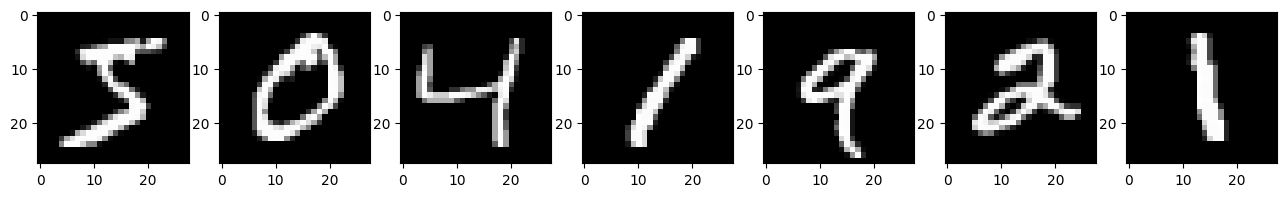

      5          0          4          1          9          2          1


In [8]:
draw_examples(x_train[:7], captions=y_train)

In [9]:
num_classes = 10

x_train = x_train.reshape(60000, 784)  # 784 = 28 * 28
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255
x_test /= 255
print("{} przykładów uczących".format(x_train.shape[0]))
print("{} przykładów testowych".format(x_test.shape[0]))

# przekonwertuj wektory klas na binarne macierze klas
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

60000 przykładów uczących
10000 przykładów testowych


In [10]:
model = keras.Sequential()
model.add(Dense(512, activation="relu", input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation="softmax"))
model.summary()

2023-01-26 10:52:27.077963: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-26 10:52:27.078089: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-26 10:52:27.078807: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ELLIOT): /proc/driver/nvidia/version does not exist
2023-01-26 10:52:27.095828: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 10)                5130      
                                                                 
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


In [11]:
print(x_train.shape, y_train.shape)

(60000, 784) (60000, 10)


In [12]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.RMSprop(),
    metrics=["accuracy"],
)

model.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=5,
    verbose=1,
    validation_data=(x_test, y_test),
)

2023-01-26 10:52:27.713204: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/5
469/469 [==============================] - 13s 25ms/step - loss: 0.2303 - accuracy: 0.9290 - val_loss: 0.1023 - val_accuracy: 0.9684
Epoch 2/5
469/469 [==============================] - 9s 20ms/step - loss: 0.0840 - accuracy: 0.9742 - val_loss: 0.0794 - val_accuracy: 0.9754
Epoch 3/5
469/469 [==============================] - 9s 20ms/step - loss: 0.0548 - accuracy: 0.9826 - val_loss: 0.0603 - val_accuracy: 0.9828
Epoch 4/5
469/469 [==============================] - 9s 20ms/step - loss: 0.0367 - accuracy: 0.9883 - val_loss: 0.0707 - val_accuracy: 0.9796
Epoch 5/5
469/469 [==============================] - 9s 19ms/step - loss: 0.0278 - accuracy: 0.9912 - val_loss: 0.0765 - val_accuracy: 0.9785


In [13]:
score = model.evaluate(x_test, y_test, verbose=0)

print("Test loss: {}".format(score[0]))
print("Test accuracy: {}".format(score[1]))

Test loss: 0.07645954936742783
Test accuracy: 0.9785000085830688


Warstwa _dropout_ to metoda regularyzacji, służy zapobieganiu nadmiernemu dopasowaniu sieci. Polega na tym, że część węzłów sieci jest usuwana w sposób losowy.

In [14]:
# Bez warstw Dropout

num_classes = 10

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)  # 784 = 28 * 28
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255
x_test /= 255

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model_no_dropout = keras.Sequential()
model_no_dropout.add(Dense(512, activation="relu", input_shape=(784,)))
model_no_dropout.add(Dense(512, activation="relu"))
model_no_dropout.add(Dense(num_classes, activation="softmax"))
model_no_dropout.summary()

model_no_dropout.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.RMSprop(),
    metrics=["accuracy"],
)

model_no_dropout.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=5,
    verbose=1,
    validation_data=(x_test, y_test),
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 512)               401920    
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dense_5 (Dense)             (None, 10)                5130      
                                                                 
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5


2023-01-26 10:53:20.710986: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


469/469 [==============================] - 10s 19ms/step - loss: 0.2283 - accuracy: 0.9302 - val_loss: 0.0983 - val_accuracy: 0.9685
Epoch 2/5
469/469 [==============================] - 10s 22ms/step - loss: 0.0849 - accuracy: 0.9736 - val_loss: 0.0996 - val_accuracy: 0.9673
Epoch 3/5
469/469 [==============================] - 10s 22ms/step - loss: 0.0549 - accuracy: 0.9829 - val_loss: 0.0704 - val_accuracy: 0.9777
Epoch 4/5
469/469 [==============================] - 10s 21ms/step - loss: 0.0380 - accuracy: 0.9877 - val_loss: 0.0645 - val_accuracy: 0.9797
Epoch 5/5
469/469 [==============================] - 20s 43ms/step - loss: 0.0276 - accuracy: 0.9910 - val_loss: 0.0637 - val_accuracy: 0.9825


In [15]:
# Bez warstw Dropout

score = model_no_dropout.evaluate(x_test, y_test, verbose=0)

print("Test loss (no dropout): {}".format(score[0]))
print("Test accuracy (no dropout): {}".format(score[1]))

Test loss (no dropout): 0.06374581903219223
Test accuracy (no dropout): 0.9825000166893005


In [18]:
# Więcej warstw, inna funkcja aktywacji

num_classes = 10

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)  # 784 = 28 * 28
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255
x_test /= 255

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model3 = keras.Sequential()
model3.add(Dense(2500, activation="tanh", input_shape=(784,)))
model3.add(Dense(2000, activation="tanh"))
model3.add(Dense(1500, activation="tanh"))
model3.add(Dense(1000, activation="tanh"))
model3.add(Dense(500, activation="tanh"))
model3.add(Dense(num_classes, activation="softmax"))
model3.summary()

model3.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.RMSprop(),
    metrics=["accuracy"],
)

model3.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=10,
    verbose=1,
    validation_data=(x_test, y_test),
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 2500)              1962500   
                                                                 
 dense_7 (Dense)             (None, 2000)              5002000   
                                                                 
 dense_8 (Dense)             (None, 1500)              3001500   
                                                                 
 dense_9 (Dense)             (None, 1000)              1501000   
                                                                 
 dense_10 (Dense)            (None, 500)               500500    
                                                                 
 dense_11 (Dense)            (None, 10)                5010      
                                                                 
Total params: 11,972,510
Trainable params: 11,972,510


2023-01-26 11:06:02.193383: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


469/469 [==============================] - 140s 294ms/step - loss: 0.6488 - accuracy: 0.8175 - val_loss: 0.2686 - val_accuracy: 0.9211
Epoch 2/10
469/469 [==============================] - 147s 313ms/step - loss: 0.2135 - accuracy: 0.9367 - val_loss: 0.2251 - val_accuracy: 0.9363
Epoch 3/10
469/469 [==============================] - 105s 224ms/step - loss: 0.1549 - accuracy: 0.9535 - val_loss: 0.1535 - val_accuracy: 0.9533
Epoch 4/10
469/469 [==============================] - 94s 200ms/step - loss: 0.1210 - accuracy: 0.9635 - val_loss: 0.1412 - val_accuracy: 0.9599
Epoch 5/10
469/469 [==============================] - 93s 199ms/step - loss: 0.0985 - accuracy: 0.9704 - val_loss: 0.1191 - val_accuracy: 0.9650
Epoch 6/10
469/469 [==============================] - 105s 224ms/step - loss: 0.0834 - accuracy: 0.9746 - val_loss: 0.0959 - val_accuracy: 0.9732
Epoch 7/10
469/469 [==============================] - 111s 236ms/step - loss: 0.0664 - accuracy: 0.9797 - val_loss: 0.1071 - val_accuracy

In [19]:
# Więcej warstw, inna funkcja aktywacji

score = model3.evaluate(x_test, y_test, verbose=0)

print("Test loss: {}".format(score[0]))
print("Test accuracy: {}".format(score[1]))

Test loss: 0.10930903255939484
Test accuracy: 0.9735999703407288


### Przykład: 4-pikselowy aparat fotograficzny

https://www.youtube.com/watch?v=ILsA4nyG7I0

In [20]:
def generate_example(description):
    variant = random.choice([1, -1])
    if description == "s":  # solid
        return (
            np.array([[1.0, 1.0], [1.0, 1.0]])
            if variant == 1
            else np.array([[-1.0, -1.0], [-1.0, -1.0]])
        )
    elif description == "v":  # vertical
        return (
            np.array([[1.0, -1.0], [1.0, -1.0]])
            if variant == 1
            else np.array([[-1.0, 1.0], [-1.0, 1.0]])
        )
    elif description == "d":  # diagonal
        return (
            np.array([[1.0, -1.0], [-1.0, 1.0]])
            if variant == 1
            else np.array([[-1.0, 1.0], [1.0, -1.0]])
        )
    elif description == "h":  # horizontal
        return (
            np.array([[1.0, 1.0], [-1.0, -1.0]])
            if variant == 1
            else np.array([[-1.0, -1.0], [1.0, 1.0]])
        )
    else:
        return np.array(
            [
                [random.uniform(-1, 1), random.uniform(-1, 1)],
                [random.uniform(-1, 1), random.uniform(-1, 1)],
            ]
        )

In [22]:
import numpy as np
import random

num_classes = 4

trainset_size = 4000
testset_size = 1000

y4_train = np.array([random.choice(["s", "v", "d", "h"]) for i in range(trainset_size)])
x4_train = np.array([generate_example(desc) for desc in y4_train])

y4_test = np.array([random.choice(["s", "v", "d", "h"]) for i in range(testset_size)])
x4_test = np.array([generate_example(desc) for desc in y4_test])

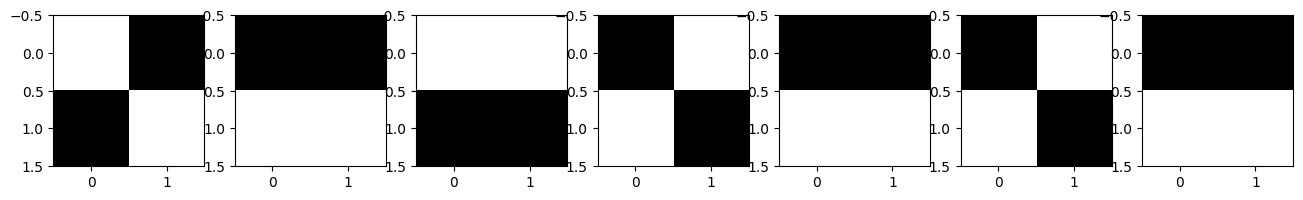

      d          h          h          d          h          d          h


In [23]:
draw_examples(x4_train[:7], captions=y4_train)

In [24]:
x4_train = x4_train.reshape(trainset_size, 4)
x4_test = x4_test.reshape(testset_size, 4)
x4_train = x4_train.astype("float32")
x4_test = x4_test.astype("float32")

y4_train = np.array([{"s": 0, "v": 1, "d": 2, "h": 3}[desc] for desc in y4_train])
y4_test = np.array([{"s": 0, "v": 1, "d": 2, "h": 3}[desc] for desc in y4_test])

y4_train = keras.utils.to_categorical(y4_train, num_classes)
y4_test = keras.utils.to_categorical(y4_test, num_classes)

In [25]:
model4 = keras.Sequential()
model4.add(Dense(4, activation="tanh", input_shape=(4,)))
model4.add(Dense(4, activation="tanh"))
model4.add(Dense(8, activation="relu"))
model4.add(Dense(num_classes, activation="softmax"))
model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 4)                 20        
                                                                 
 dense_13 (Dense)            (None, 4)                 20        
                                                                 
 dense_14 (Dense)            (None, 8)                 40        
                                                                 
 dense_15 (Dense)            (None, 4)                 36        
                                                                 
Total params: 116
Trainable params: 116
Non-trainable params: 0
_________________________________________________________________


In [26]:
model4.layers[0].set_weights(
    [
        np.array(
            [
                [1.0, 0.0, 1.0, 0.0],
                [0.0, 1.0, 0.0, 1.0],
                [1.0, 0.0, -1.0, 0.0],
                [0.0, 1.0, 0.0, -1.0],
            ],
            dtype=np.float32,
        ),
        np.array([0.0, 0.0, 0.0, 0.0], dtype=np.float32),
    ]
)
model4.layers[1].set_weights(
    [
        np.array(
            [
                [1.0, -1.0, 0.0, 0.0],
                [1.0, 1.0, 0.0, 0.0],
                [0.0, 0.0, 1.0, -1.0],
                [0.0, 0.0, -1.0, -1.0],
            ],
            dtype=np.float32,
        ),
        np.array([0.0, 0.0, 0.0, 0.0], dtype=np.float32),
    ]
)
model4.layers[2].set_weights(
    [
        np.array(
            [
                [1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                [0.0, 0.0, 1.0, -1.0, 0.0, 0.0, 0.0, 0.0],
                [0.0, 0.0, 0.0, 0.0, 1.0, -1.0, 0.0, 0.0],
                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, -1.0],
            ],
            dtype=np.float32,
        ),
        np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], dtype=np.float32),
    ]
)

In [27]:
model4.layers[3].set_weights(
    [
        np.array(
            [
                [1.0, 0.0, 0.0, 0.0],
                [1.0, 0.0, 0.0, 0.0],
                [0.0, 1.0, 0.0, 0.0],
                [0.0, 1.0, 0.0, 0.0],
                [0.0, 0.0, 1.0, 0.0],
                [0.0, 0.0, 1.0, 0.0],
                [0.0, 0.0, 0.0, 1.0],
                [0.0, 0.0, 0.0, 1.0],
            ],
            dtype=np.float32,
        ),
        np.array([0.0, 0.0, 0.0, 0.0], dtype=np.float32),
    ]
)

model4.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adagrad(),
    metrics=["accuracy"],
)

In [28]:
for layer in model4.layers:
    print(layer.get_weights())

[array([[ 1.,  0.,  1.,  0.],
       [ 0.,  1.,  0.,  1.],
       [ 1.,  0., -1.,  0.],
       [ 0.,  1.,  0., -1.]], dtype=float32), array([0., 0., 0., 0.], dtype=float32)]
[array([[ 1., -1.,  0.,  0.],
       [ 1.,  1.,  0.,  0.],
       [ 0.,  0.,  1., -1.],
       [ 0.,  0., -1., -1.]], dtype=float32), array([0., 0., 0., 0.], dtype=float32)]
[array([[ 1., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1., -1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1., -1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1., -1.]], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)]
[array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32), array([0., 0., 0., 0.], dtype=float32)]


In [29]:
model4.predict([np.array([[1.0, 1.0], [-1.0, -1.0]]).reshape(1, 4)])

1/1 [==============================] - 1s 872ms/step


array([[0.17831734, 0.17831734, 0.17831734, 0.465048  ]], dtype=float32)

In [30]:
score = model4.evaluate(x4_test, y4_test, verbose=0)

print("Test loss: {}".format(score[0]))
print("Test accuracy: {}".format(score[1]))

Test loss: 0.7656148672103882
Test accuracy: 1.0


In [32]:
model5 = keras.Sequential()
model5.add(Dense(4, activation="tanh", input_shape=(4,)))
model5.add(Dense(4, activation="tanh"))
model5.add(Dense(8, activation="relu"))
model5.add(Dense(num_classes, activation="softmax"))
model5.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.RMSprop(),
    metrics=["accuracy"],
)
model5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 4)                 20        
                                                                 
 dense_17 (Dense)            (None, 4)                 20        
                                                                 
 dense_18 (Dense)            (None, 8)                 40        
                                                                 
 dense_19 (Dense)            (None, 4)                 36        
                                                                 
Total params: 116
Trainable params: 116
Non-trainable params: 0
_________________________________________________________________


In [33]:
model5.fit(x4_train, y4_train, epochs=8, validation_data=(x4_test, y4_test))

Epoch 1/8
125/125 [==============================] - 3s 8ms/step - loss: 1.3014 - accuracy: 0.4947 - val_loss: 1.1876 - val_accuracy: 0.6040
Epoch 2/8
125/125 [==============================] - 1s 6ms/step - loss: 1.0779 - accuracy: 0.7395 - val_loss: 0.9865 - val_accuracy: 0.8730
Epoch 3/8
125/125 [==============================] - 1s 4ms/step - loss: 0.8925 - accuracy: 0.8382 - val_loss: 0.8114 - val_accuracy: 0.7460
Epoch 4/8
125/125 [==============================] - 0s 4ms/step - loss: 0.7266 - accuracy: 0.8060 - val_loss: 0.6622 - val_accuracy: 0.8730
Epoch 5/8
125/125 [==============================] - 0s 4ms/step - loss: 0.5890 - accuracy: 0.8765 - val_loss: 0.5392 - val_accuracy: 0.8730
Epoch 6/8
125/125 [==============================] - 1s 4ms/step - loss: 0.4738 - accuracy: 0.8838 - val_loss: 0.4293 - val_accuracy: 0.8730
Epoch 7/8
125/125 [==============================] - 1s 5ms/step - loss: 0.3636 - accuracy: 0.9337 - val_loss: 0.3191 - val_accuracy: 1.0000
Epoch 8/8
125

In [34]:
model5.predict([np.array([[1.0, 1.0], [-1.0, -1.0]]).reshape(1, 4)])

1/1 [==============================] - 0s 106ms/step


array([[1.5366691e-01, 4.4674356e-04, 4.7448810e-02, 7.9843748e-01]],
      dtype=float32)

In [35]:
score = model5.evaluate(x4_test, y4_test, verbose=0)

print("Test loss: {}".format(score[0]))
print("Test accuracy: {}".format(score[1]))

Test loss: 0.22015966475009918
Test accuracy: 1.0


In [36]:
import contextlib


@contextlib.contextmanager
def printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    try:
        yield
    finally:
        np.set_printoptions(**original)

In [37]:
with printoptions(precision=1, suppress=True):
    for layer in model5.layers:
        print(layer.get_weights())

[array([[-0.8,  0.1, -0.6,  0.1],
       [-0.9, -0.7, -1. ,  0.6],
       [-0.3,  0.5,  0.5,  0.3],
       [ 0.4,  0.3, -0.9, -0.8]], dtype=float32), array([ 0., -0.,  0.,  0.], dtype=float32)]
[array([[-1.1,  1.2, -0.6, -0.6],
       [-1.1, -0.2, -0.7, -1.3],
       [ 0.6,  0.9,  0.3, -1.3],
       [ 0.8,  0.3,  0.7,  0.4]], dtype=float32), array([ 0.3,  0.5, -0.4,  0.5], dtype=float32)]
[array([[ 0.5,  0.4, -0.4,  0.3,  0.8, -1.4, -1.1,  0.8],
       [ 0.5, -1.3,  0.3,  0.4, -1.3,  0.2,  0.9,  0.7],
       [-0.2, -0.1, -0.5, -0.2,  1.2, -0.4, -0.4,  1.1],
       [-1.1,  0.4,  1.3, -1.1,  1. , -1.1, -0.8,  0.3]], dtype=float32), array([ 0.2,  0.2,  0.1,  0.1,  0.2,  0.1, -0.2,  0. ], dtype=float32)]
[array([[ 0.7,  0.8, -1.5, -0.2],
       [ 0.7, -0.9, -1.2,  0.2],
       [-0.4,  1.1, -0.1, -1.6],
       [ 0.3,  0.8, -1.4,  0.4],
       [ 0.2, -1.4, -0.3,  0.5],
       [-0.2, -1.2,  0.6,  0.7],
       [-0.1, -1.5,  0.3, -0.1],
       [-1.4,  0.1,  1.2, -0. ]], dtype=float32), array([-